In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [180]:
!pip install xgboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [187]:
df = pd.read_csv("gender_submission.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [120]:
df = pd.concat([train_df, test_df], ignore_index=True)


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [122]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [123]:
df.drop(columns = ["Cabin"],inplace = True)


In [124]:
df.dropna(subset = ["Embarked"],inplace = True)



In [125]:
df["Age"] = df["Age"].fillna(df["Age"].median)
df["Fare"] = df["Fare"].fillna(df["Fare"].median)


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1307 non-null   int64  
 1   Survived     889 non-null    float64
 2   Pclass       1307 non-null   int64  
 3   Name         1307 non-null   object 
 4   Sex          1307 non-null   object 
 5   Age          1307 non-null   object 
 6   SibSp        1307 non-null   int64  
 7   Parch        1307 non-null   int64  
 8   Ticket       1307 non-null   object 
 9   Fare         1307 non-null   object 
 10  Embarked     1307 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 122.5+ KB


In [127]:
# Training data (where Survived is known)
train_data = df[df['Survived'].notna()].copy()

# Test data (where Survived is NaN — to be predicted)
test_data = df[df['Survived'].isna()].copy()
test_data  = test_data.drop(columns = "Survived")

In [128]:
train_data.drop(columns = "Name",axis = 1,inplace = True)
test_data.drop(columns = "Name",axis = 1,inplace = True)

In [129]:
test_data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
891,892,3,male,34.5,0,0,330911,7.8292,Q
892,893,3,female,47.0,1,0,363272,7.0,S
893,894,2,male,62.0,0,0,240276,9.6875,Q
894,895,3,male,27.0,0,0,315154,8.6625,S
895,896,3,female,22.0,1,1,3101298,12.2875,S
...,...,...,...,...,...,...,...,...,...
1304,1305,3,male,<bound method Series.median of 0 22.0\n1...,0,0,A.5. 3236,8.05,S
1305,1306,1,female,39.0,0,0,PC 17758,108.9,C
1306,1307,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.25,S
1307,1308,3,male,<bound method Series.median of 0 22.0\n1...,0,0,359309,8.05,S


In [130]:
# Convert 'Sex' to binary values: 1 for 'male', 0 for 'female'
test_data["Sex"] = test_data["Sex"].apply(lambda x: 1 if x == "male" else 0)
train_data["Sex"] = train_data["Sex"].apply(lambda x: 1 if x == "male" else 0)


In [131]:
# One-Hot Encoding for 'Embarked'
test_data = pd.get_dummies(test_data, columns=["Embarked"], drop_first=True)
train_data = pd.get_dummies(train_data, columns=["Embarked"], drop_first=True)


In [132]:
test_data.drop(columns = "Ticket",inplace = True)

In [133]:
# Convert all columns to numeric, invalid parsing will be set to NaN
test_data = test_data.apply(pd.to_numeric, errors='coerce')
train_data = train_data.apply(pd.to_numeric, errors='coerce')




In [134]:
# Convert specific boolean columns to 0 and 1
test_data['Embarked_Q'] = test_data['Embarked_Q'].astype(int)
test_data['Embarked_S'] = test_data['Embarked_S'].astype(int)

train_data['Embarked_Q'] = train_data['Embarked_Q'].astype(int)
train_data['Embarked_S'] = train_data['Embarked_S'].astype(int)


In [135]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1  # Add 1 for the passenger themselves
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1


In [136]:
train_data.corrwith(df['Survived'])

PassengerId   -0.005028
Survived       1.000000
Pclass        -0.335549
Sex           -0.541585
Age           -0.082446
SibSp         -0.034040
Parch          0.083151
Ticket        -0.121581
Fare           0.255290
Embarked_Q     0.004536
Embarked_S    -0.151777
FamilySize     0.018277
dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

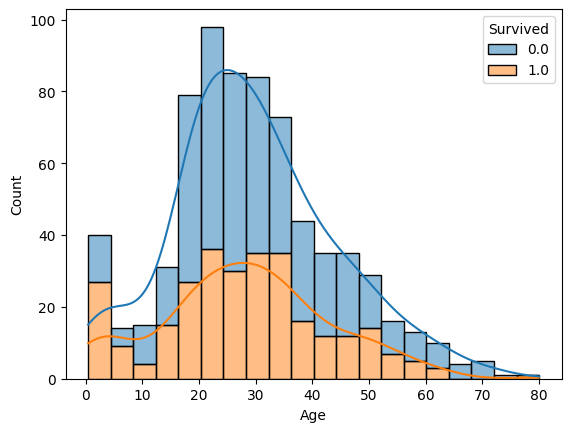

In [137]:
sns.histplot(data=train_data, x='Age', hue='Survived', bins=20, kde=True, multiple='stack')


array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Ticket'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'Embarked_Q'}>,
        <Axes: title={'center': 'Embarked_S'}>,
        <Axes: title={'center': 'FamilySize'}>]], dtype=object)

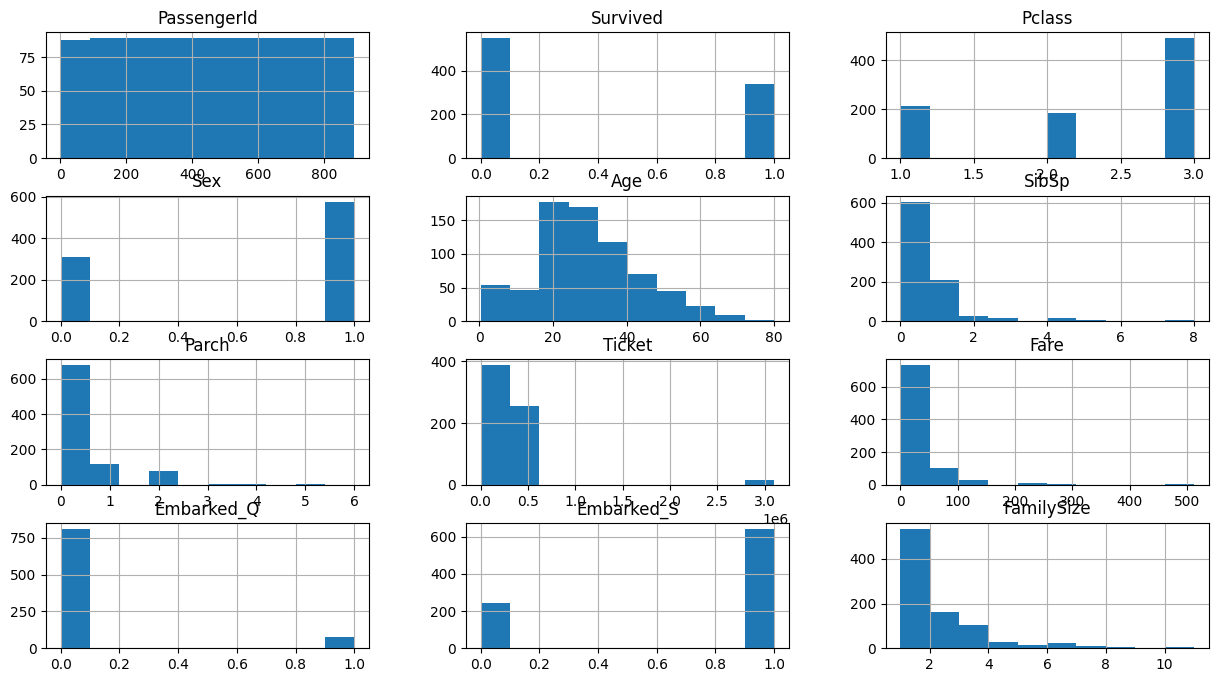

In [138]:
train_data.hist(figsize = (15,8))


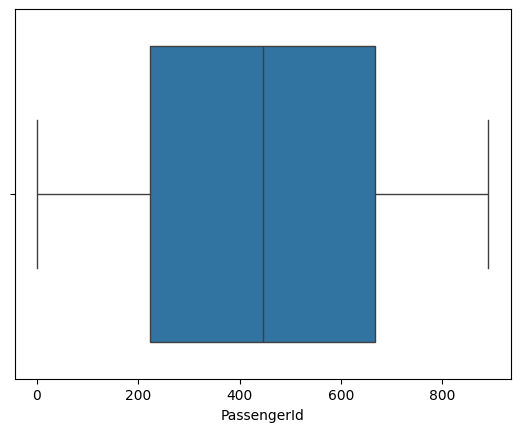

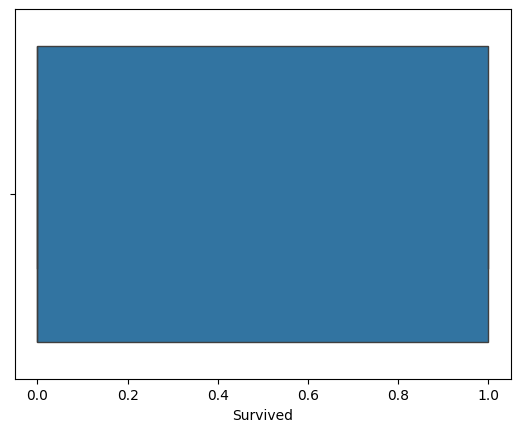

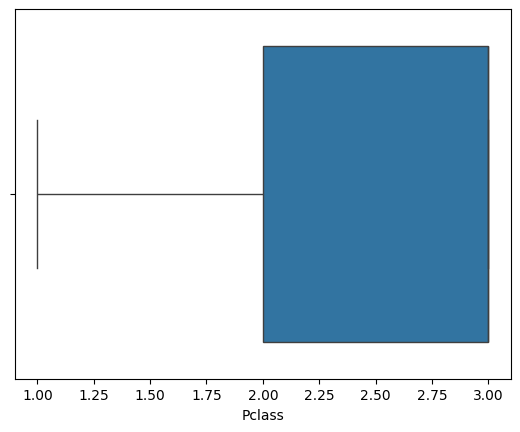

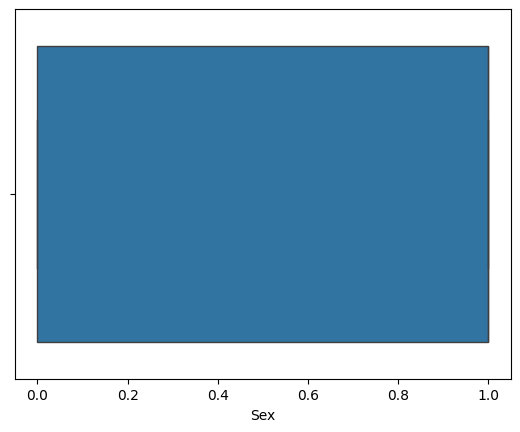

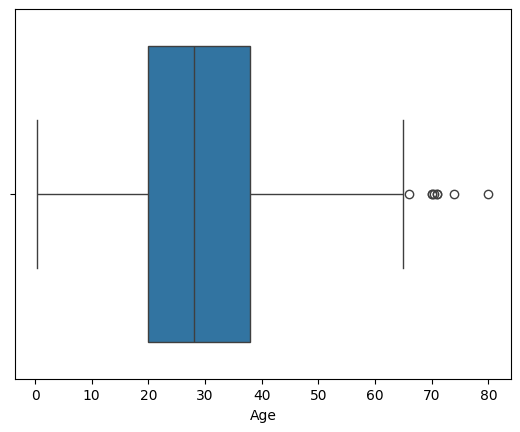

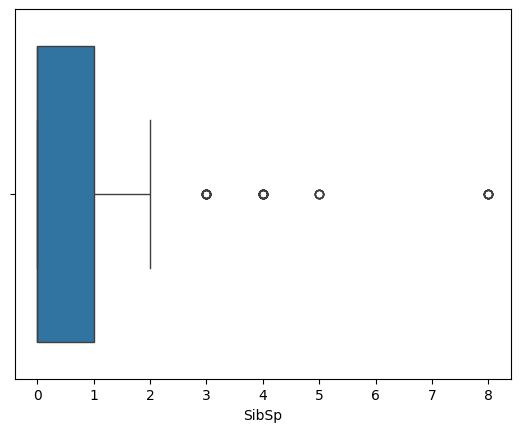

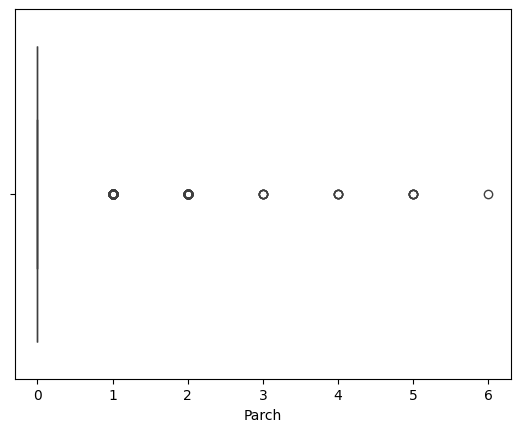

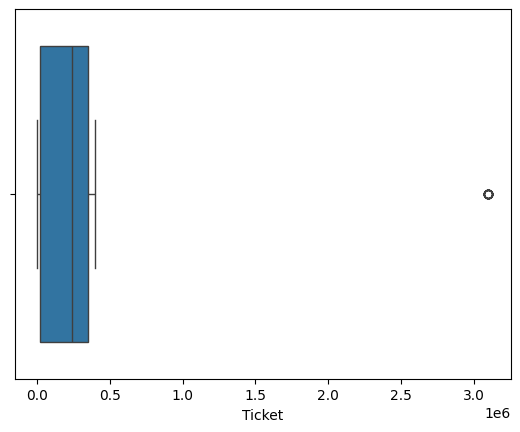

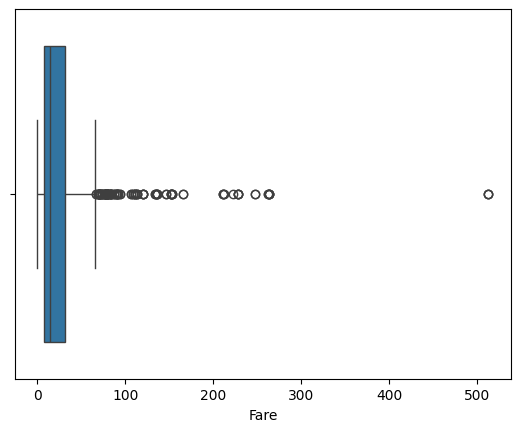

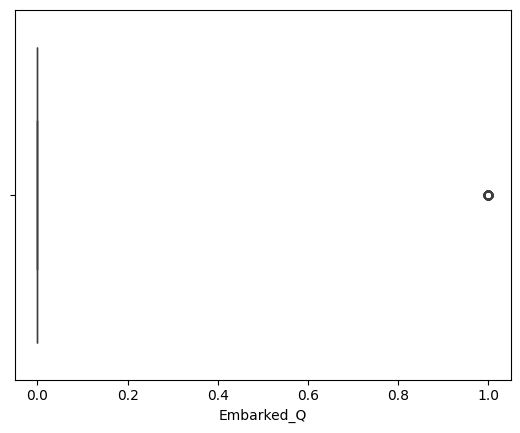

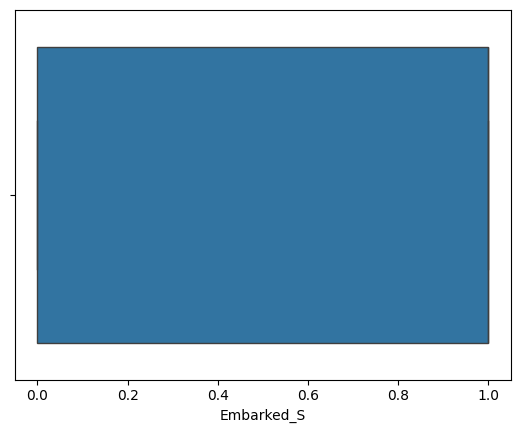

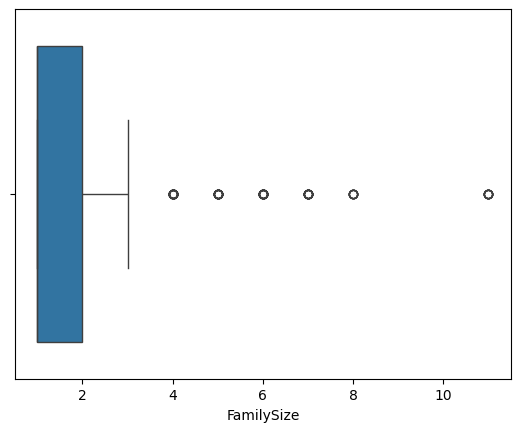

In [139]:
for column in train_data.columns.array:
    sns.boxplot(x=train_data[column])
    plt.show()

In [140]:
train_data.columns.array

<NumpyExtensionArray>
['PassengerId',    'Survived',      'Pclass',         'Sex',         'Age',
       'SibSp',       'Parch',      'Ticket',        'Fare',  'Embarked_Q',
  'Embarked_S',  'FamilySize']
Length: 12, dtype: object

In [147]:

train_data['Fare'] = np.log1p(train_data['Fare'])  # log(Fare + 1)

test_data['Fare'] = np.log1p(test_data['Fare'])  # log(Fare + 1)



array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Sex'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Embarked_Q'}>,
        <Axes: title={'center': 'Embarked_S'}>],
       [<Axes: title={'center': 'FamilySize'}>, <Axes: >, <Axes: >]],
      dtype=object)

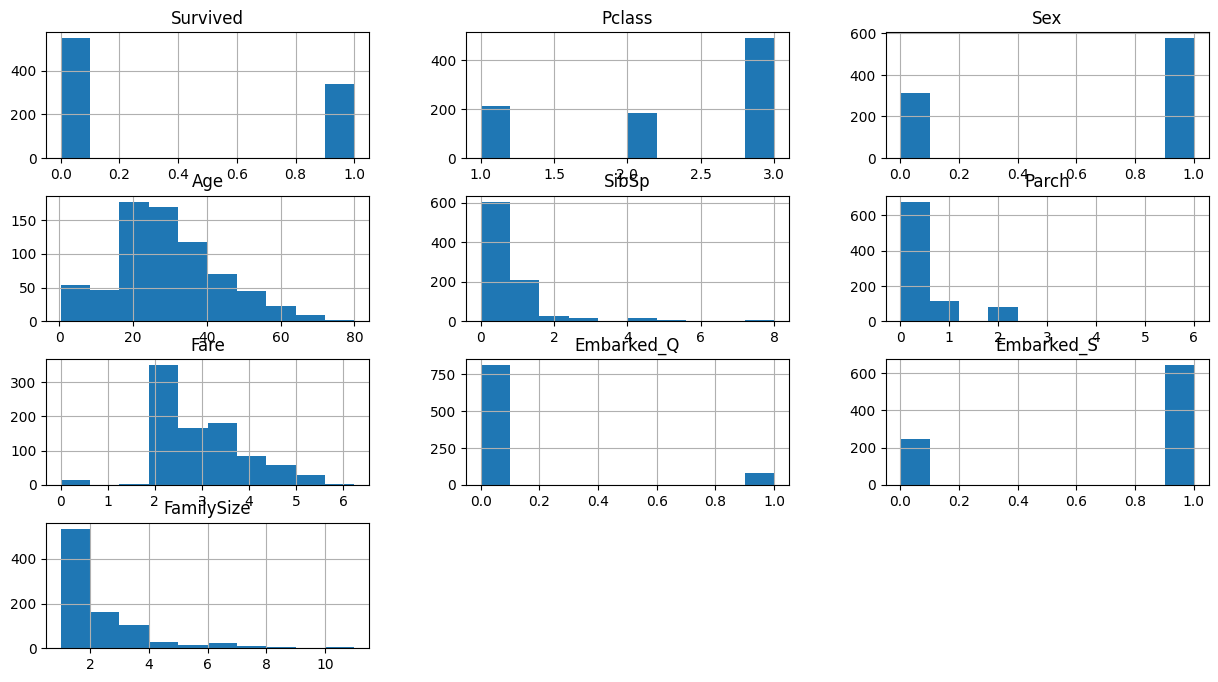

In [148]:
train_data.hist(figsize = (15,8))

In [150]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1


In [151]:
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,FamilySize
0,0.0,3,1,22.0,1,0,2.110213,0,1,2
1,1.0,1,0,38.0,1,0,4.280593,0,0,2
2,1.0,3,0,26.0,0,0,2.188856,0,1,1
3,1.0,1,0,35.0,1,0,3.990834,0,1,2
4,0.0,3,1,35.0,0,0,2.202765,0,1,1
...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,1,27.0,0,0,2.639057,0,1,1
887,1.0,1,0,19.0,0,0,3.433987,0,1,1
888,0.0,3,0,NaN,1,2,3.196630,0,1,4
889,1.0,1,1,26.0,0,0,3.433987,0,0,1


In [153]:
#binning
age_bins = [0, 12, 20, 40, 60, 80]
train_data['AgeBin'] = pd.cut(train_data['Age'], bins=age_bins, labels=False)
test_data['AgeBin'] = pd.cut(test_data['Age'], bins=age_bins, labels=False)


fare_bins = pd.qcut(train_data['Fare'], 4, duplicates='drop', retbins=True)[1]


train_data['FareBin'] = pd.cut(train_data['Fare'], bins=fare_bins, labels=False, include_lowest=True)
test_data['FareBin'] = pd.cut(test_data['Fare'], bins=fare_bins, labels=False, include_lowest=True)


In [154]:
train_data.corrwith(train_data['Survived'])

Survived      1.000000
Pclass       -0.335549
Sex          -0.541585
Age          -0.082446
SibSp        -0.034040
Parch         0.083151
Fare          0.327042
Embarked_Q    0.004536
Embarked_S   -0.151777
FamilySize    0.018277
AgeBin       -0.102057
FareBin       0.296663
dtype: float64

In [155]:
low_corr_columns = [
    'Age',
    'SibSp',
    'Parch',
    'Embarked_Q',
    'FamilySize'
]
train_data.drop(columns = low_corr_columns,inplace = True)
test_data.drop(columns = low_corr_columns,inplace = True)

In [156]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier()

In [166]:
test_data.drop(columns = "PassengerId",inplace = True)

In [167]:
prediction_data = test_data.copy()
df = train_data.copy()


In [169]:
x = df.drop(columns = "Survived")
y = df['Survived']


In [173]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [174]:
rfc_model.fit(x_train,y_train)

RandomForestClassifier()

In [176]:
y_pred = rfc_model.predict(x_test)

In [177]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")


Model Accuracy: 0.7978


In [182]:
from xgboost import XGBClassifier

xgbc_model = XGBClassifier()
xgbc_model.fit(x_train,y_train)
y_pred = rfc_model.predict(x_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.7978


In [186]:
#time for tuning mothafacs
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10, 15]
}


model = RandomForestClassifier(random_state=42)


grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')


grid_search.fit(x_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

from sklearn.metrics import accuracy_score
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Best CV Accuracy: 0.8255983453166552
Test Accuracy: 0.797752808988764


In [188]:
df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
